# CM4105 Cell Counter

## Preliminaries

In [ ]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install and log into Weights & Biases for logging
!pip install wandb
import wandb
wandb.login()

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 144 kB 59.5 MB/s 
     |████████████████████████████████| 181 kB 50.8 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=986305956d4a70604f8ef11735fbb6631ed3b4934538827b92281d6550f05045
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# clone YOLOv5 & install dependencies
!git clone https://github.com/ultralytics/yolov5 # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 13033, done.
remote: Total 13033 (delta 0), reused 0 (delta 0), pack-reused 13033
Receiving objects: 100% (13033/13033), 11.95 MiB | 25.03 MiB/s, done.
Resolving deltas: 100% (9054/9054), done.
/content/yolov5
     |████████████████████████████████| 596 kB 5.3 MB/s 
Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


## Training

In [ ]:
# Train a new model on the dataset
!python train.py --project cm4105 --img 224 --batch 128 --epochs 300 --data '/content/drive/MyDrive/dataset/data.yaml' --weights yolov5l.pt --cache

wandb: Currently logged in as: adamindeen (use `wandb login --relogin` to force relogin)
train: weights=yolov5l.pt, cfg=, data=/content/drive/MyDrive/dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=128, imgsz=224, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=cm4105, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, ob

## Counting

In [1]:
import torch
import os
from google.colab.patches import cv2_imshow
import shutil

# List to hold cell counts for all 4 test images
model_counts = []
# The pretrained model to use (1-7 or 's' for YOLOv5s)
model = 2

In [2]:
if model == 's':
  # Load YOLOv5s
  model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
else:
  # Load custom model
  shutil.copy(f'/content/drive/MyDrive/CM4105/models/run{model}/best.pt', '/content/')
  model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/best.pt')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-5-4 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


In [3]:
from torch._C import StringType
from IPython.display import display

'''
Run inference on, and return a cell count for, the given image
'''
def count(img: StringType, edge: int = 2):
  patches = []

  # Run inference on all patches in the image directory
  for i in os.listdir(f'/content/drive/MyDrive/CM4105/dataset/images/{img}'):
    patches.append(f'/content/drive/MyDrive/CM4105/dataset/images/{img}/' + i)
  results = model(patches)

  # Iterate through the DataFrames and sum their lengths for a count of cells in the image
  dfs = results.pandas().xyxy
  count = 0
  for df in dfs:
    # Remove cells along the top-left edges of the image
    df_trim = df.loc[df['xmin'] > edge]
    df_trim = df_trim.loc[df['ymin'] > edge]
    count += len(df_trim)

  # Print the first DataFrame in the results
  print(f'First patch of image {img}:')
  display(dfs[0])
  print(dfs[0].to_latex())

  # Display the first image in the results
  results.render()
  cv2_imshow(results.imgs[0])

  return count

First patch of image test_34:


,xmin,ymin,xmax,ymax,confidence,class,name


\begin{tabular}{llllllll}
\toprule
Empty DataFrame
Columns: Index(['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name'], dtype='object')
Index: Index([], dtype='object') \\
\bottomrule
\end{tabular}



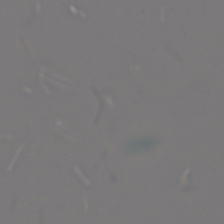

[193]


In [4]:
model_counts.append(count('test_34'))
print(model_counts)

First patch of image test_39:


,xmin,ymin,xmax,ymax,confidence,class,name


\begin{tabular}{llllllll}
\toprule
Empty DataFrame
Columns: Index(['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name'], dtype='object')
Index: Index([], dtype='object') \\
\bottomrule
\end{tabular}



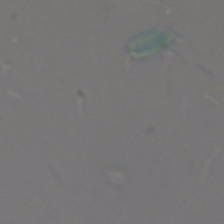

[193, 100]


In [5]:
model_counts.append(count('test_39'))
print(model_counts)

First patch of image test_41:


,xmin,ymin,xmax,ymax,confidence,class,name
0,75.893990,69.085136,105.879059,96.627403,0.750943,0,cell
1,29.146824,56.450275,69.507744,84.641159,0.744812,0,cell
2,58.688450,63.193928,87.090523,89.821877,0.697359,0,cell
3,0.000000,44.773205,38.310505,73.991913,0.661700,0,cell
4,1.041833,169.282349,36.268791,198.533752,0.640781,0,cell
5,191.274399,172.595840,224.000000,202.301834,0.630377,0,cell
6,92.292030,72.310440,128.572678,101.630936,0.587828,0,cell
7,116.679451,79.314751,147.367172,111.722885,0.481159,0,cell
8,123.143204,90.077225,171.629639,116.758293,0.474041,0,cell
9,164.539627,98.761833,210.686905,131.060379,0.462704,0,cell


\begin{tabular}{lrrrrrrl}
\toprule
{} &        xmin &        ymin &        xmax &        ymax &  confidence &  class &  name \\
\midrule
0  &   75.893990 &   69.085136 &  105.879059 &   96.627403 &    0.750943 &      0 &  cell \\
1  &   29.146824 &   56.450275 &   69.507744 &   84.641159 &    0.744812 &      0 &  cell \\
2  &   58.688450 &   63.193928 &   87.090523 &   89.821877 &    0.697359 &      0 &  cell \\
3  &    0.000000 &   44.773205 &   38.310505 &   73.991913 &    0.661700 &      0 &  cell \\
4  &    1.041833 &  169.282349 &   36.268791 &  198.533752 &    0.640781 &      0 &  cell \\
5  &  191.274399 &  172.595840 &  224.000000 &  202.301834 &    0.630377 &      0 &  cell \\
6  &   92.292030 &   72.310440 &  128.572678 &  101.630936 &    0.587828 &      0 &  cell \\
7  &  116.679451 &   79.314751 &  147.367172 &  111.722885 &    0.481159 &      0 &  cell \\
8  &  123.143204 &   90.077225 &  171.629639 &  116.758293 &    0.474041 &      0 &  cell \\
9  &  164.539627 &   98.76

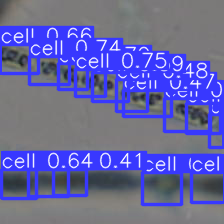

[193, 100, 147]


In [6]:
model_counts.append(count('test_41'))
print(model_counts)

First patch of image test_44:


,xmin,ymin,xmax,ymax,confidence,class,name
0,171.364731,201.148102,199.427536,224.000000,0.784725,0,cell
1,32.783836,56.920052,71.342056,85.330605,0.673251,0,cell
2,0.000000,62.408360,19.995903,91.002068,0.668127,0,cell
3,81.289337,53.663631,123.687935,83.133606,0.647899,0,cell
4,53.083363,72.040642,85.592941,99.588737,0.595215,0,cell
5,76.838242,94.306755,115.534416,126.955360,0.592176,0,cell
6,137.074982,69.043953,178.512253,102.128075,0.591142,0,cell
7,191.122925,189.110565,224.000000,224.000000,0.545035,0,cell
8,173.469330,83.511589,219.548203,115.179283,0.539574,0,cell
9,104.485970,134.723358,146.102661,166.917953,0.516688,0,cell


\begin{tabular}{lrrrrrrl}
\toprule
{} &        xmin &        ymin &        xmax &        ymax &  confidence &  class &  name \\
\midrule
0  &  171.364731 &  201.148102 &  199.427536 &  224.000000 &    0.784725 &      0 &  cell \\
1  &   32.783836 &   56.920052 &   71.342056 &   85.330605 &    0.673251 &      0 &  cell \\
2  &    0.000000 &   62.408360 &   19.995903 &   91.002068 &    0.668127 &      0 &  cell \\
3  &   81.289337 &   53.663631 &  123.687935 &   83.133606 &    0.647899 &      0 &  cell \\
4  &   53.083363 &   72.040642 &   85.592941 &   99.588737 &    0.595215 &      0 &  cell \\
5  &   76.838242 &   94.306755 &  115.534416 &  126.955360 &    0.592176 &      0 &  cell \\
6  &  137.074982 &   69.043953 &  178.512253 &  102.128075 &    0.591142 &      0 &  cell \\
7  &  191.122925 &  189.110565 &  224.000000 &  224.000000 &    0.545035 &      0 &  cell \\
8  &  173.469330 &   83.511589 &  219.548203 &  115.179283 &    0.539574 &      0 &  cell \\
9  &  104.485970 &  134.72

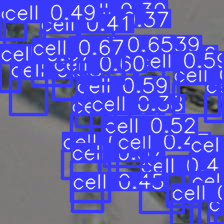

[193, 100, 147, 235]


In [7]:
model_counts.append(count('test_44'))
print(model_counts)

In [8]:
# Display counts
print(model_counts)

[193, 100, 147, 235]


## Evaluation

In [ ]:
import pandas as pd

# GT counts for test set images
images = [37, 39, 41, 44]
gt_counts = [81, 58, 86, 102]

# Construct DataFrame
df = pd.DataFrame({
    'Image': images,
    'Ground Truth': gt_counts,
    'Model Count': model_counts
    })

# Calculate absolute & percentage error
df['Num. Error'] = abs(df['Ground Truth'] - df['Model Count'])
df['% Error'] = (df['Num. Error'] / df['Ground Truth']) * 100
df.to_csv('/content/counts.csv')
df

,Image,Ground Truth,Model Count,Num. Error,% Error
0,37,81,95,14,17.283951
1,39,58,46,12,20.689655
2,41,86,95,9,10.465116
3,44,102,127,25,24.509804


In [ ]:
print(df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Image &  Ground Truth &  Model Count &  Num. Error &    \% Error \\
\midrule
0 &     37 &            81 &           95 &          14 &  17.283951 \\
1 &     39 &            58 &           46 &          12 &  20.689655 \\
2 &     41 &            86 &           95 &           9 &  10.465116 \\
3 &     44 &           102 &          127 &          25 &  24.509804 \\
\bottomrule
\end{tabular}



### Graphing

In [ ]:
!pip install kaleido
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_csv('model_counts.csv')
df
print(df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Model &  Num\_Error &   Pct\_Error \\
\midrule
0 &      1 &      74.25 &   90.767435 \\
1 &      2 &      87.00 &  103.001947 \\
2 &      3 &      83.25 &  101.850956 \\
3 &      4 &      63.00 &   75.363021 \\
4 &      5 &      62.50 &   77.071071 \\
5 &      6 &      16.00 &   20.892626 \\
6 &      7 &      15.00 &   18.237132 \\
\bottomrule
\end{tabular}



In [ ]:
fig = px.bar(df, x='Model', y='Num_Error', labels={'Num_Error': 'Num. Error'})
fig.show()
fig.write_image("num_error.png")

In [ ]:
import plotly.express as px
fig = px.bar(df, x='Model', y='Pct_Error', labels={'Pct_Error': 'Pct. Error'})
fig.show()
fig.write_image("pct_error.png")